# Exploring the batch effects in the LINCS L1000 data

---


## _Zichen Wang, Avi Ma'ayan_

<img src="http://lincs-dcic.org/images/dcic-logo/DCIC_500x375_cropped.png" style="float: right; width: 100px;"/>

#### BD2K-LINCS Data Coordination and Integration Center

#### CMap Workshop - Dec. 4th, 2018 

---

## Table of content 

- [TBA]()
- ...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, division
import os, sys
import h5py
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold

%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='whitegrid')

In [3]:
import plots
import gctx_utils

In [4]:
gctx3 = h5py.File('data/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx', 'r')

Data files were downloaded from GEO study [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742)

In [5]:
!ls -lht data/

total 83G
-rw-r--r-- 1 jovyan users 565K Nov 27 21:55 parsed_Repurposing_Hub.csv
-rw-r--r-- 1 jovyan users 1.4M Nov 27 21:03 Repurposing_Hub_export_2018.txt
drwxr-xr-x 5 jovyan users  170 Nov 27 20:43 results
-rw-r--r-- 1 jovyan users  61G Nov 19 20:00 GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx
-rw-r--r-- 1 jovyan users  22G Nov 19 15:54 GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
-rw-r--r-- 1 jovyan users  12M Nov 19 15:48 GSE92742_Broad_LINCS_sig_metrics.txt.gz
-rw-r--r-- 1 jovyan users  11M Nov 19 15:48 GSE92742_Broad_LINCS_sig_info.txt.gz
-rw-r--r-- 1 jovyan users 1.1M Nov 19 15:48 GSE92742_Broad_LINCS_pert_info.txt.gz
-rw-r--r-- 1 jovyan users  12M Nov 19 15:47 GSE92742_Broad_LINCS_inst_info.txt.gz
-rw-r--r-- 1 jovyan users 212K Nov 19 15:47 GSE92742_Broad_LINCS_gene_info.txt.gz


# 1. Examine Level 3 data

**Level 3 (Q2NORM)**: gene expression profiles of both directly measured landmark transcripts plus inferred genes. Normalized using invariant set scaling followed by quantile normalization.

Parse metadata of genes and instances

In [5]:
gene_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt.gz', 
                           compression='gzip',
                          sep='\t')
gene_info_df.set_index(gene_info_df.columns[0], inplace=True)
gene_info_df.index = gene_info_df.index.astype(str)
print(gene_info_df.shape)
gene_info_df.head()

(12328, 4)


pr_gene_symbol                                pr_gene_title  \
pr_gene_id                                                               
780                  DDR1  discoidin domain receptor tyrosine kinase 1   
7849                 PAX8                                 paired box 8   
2978               GUCA1A               guanylate cyclase activator 1A   
2049                EPHB3                              EPH receptor B3   
2101                ESRRA              estrogen related receptor alpha   

            pr_is_lm  pr_is_bing  
pr_gene_id                        
780                1           1  
7849               1           1  
2978               0           0  
2049               0           1  
2101               0           1

In [7]:
# Get the Landmark 1000 genes
LM_GENE_IDS = gene_info_df.query('pr_is_lm == 1').index
LM_GENE_IDS = LM_GENE_IDS.values.astype(np.str) # convert to np.array with np.str as dtype
print(len(LM_GENE_IDS))

978


In [8]:
# Metadata of instances
inst_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_inst_info.txt.gz', 
                          compression='gzip',
                          sep='\t')
inst_info_df.set_index(inst_info_df.columns[0], inplace=True)
print(inst_info_df.shape)
inst_info_df.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



(1319138, 10)


rna_plate rna_well pert_id  \
inst_id                                                                      
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13  ASG001_MCF7_24H_X1      F13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13  ASG001_MCF7_24H_X1      G13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13  ASG001_MCF7_24H_X1      I13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13  ASG001_MCF7_24H_X1      K13    DMSO   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13  ASG001_MCF7_24H_X1      N13    DMSO   

                                      pert_iname    pert_type  pert_dose  \
inst_id                                                                    
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13       DMSO  ctl_vehicle        0.1   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13       DMSO  ctl_vehicle        0.1   

                                      pert_dose_unit  pert_time  \
inst_id                                                           
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13              %         24   
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13              %         24   

                                      pert_time_unit cell_id  
inst_id                                                       
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13              h    MCF7  
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13              h    MCF7

In [9]:
inst_info_df['pert_type'].value_counts()

trt_cp         672128
trt_sh         448737
trt_oe          87765
ctl_vector      30400
ctl_vehicle     28463
trt_lig         25739
ctl_untrt       22072
trt_oe.mut       3834
Name: pert_type, dtype: int64

Select compount treatment (`trt_cp`) and their controls (`ctr_vehicle`)

In [10]:
inst_info_df = inst_info_df.loc[inst_info_df['pert_type'].isin(['trt_cp', 'ctl_vehicle'])]
print(inst_info_df.shape)

(700591, 10)


In [12]:
# Find the top cell lines
inst_info_df['cell_id'].value_counts().head(10)

VCAP      125539
MCF7      103448
PC3        96014
A549       60622
A375       54971
HT29       53436
HA1E       32613
HCC515     27449
HEPG2      19019
NPC        15060
Name: cell_id, dtype: int64

In [13]:
# Only examine samples from PC3 cell line
inst_info_df = inst_info_df.query('cell_id == "PC3"')
# inst_info_df = inst_info_df.query('cell_id == "NPC"')
inst_info_df.shape

(96014, 10)

In [14]:
inst_info_df.pert_type.value_counts()

trt_cp         91954
ctl_vehicle     4060
Name: pert_type, dtype: int64

In [15]:
inst_info_df.rna_plate.value_counts().head()

PCLB001_PC3_24H_X1    1055
CPC009_PC3_6H_X3       736
CPC006_PC3_24H_X2      731
CPC019_PC3_24H_X1      728
CPC001_PC3_24H_X3      721
Name: rna_plate, dtype: int64

In [16]:
inst_info_df.query('pert_type =="ctl_vehicle"')['rna_plate'].value_counts().head()

PRISM001_PC3_24H_X1    36
DEB001_PC3_6H_X2.A2    36
RAD001_PC3_6H_X2       36
PRISM001_PC3_6H_X1     34
DEB001_PC3_24H_X2      32
Name: rna_plate, dtype: int64

In [17]:
# Extract batch and det_plate from the instance_id
inst_info_df['batch'] = inst_info_df['rna_plate'].map(lambda x: '_'.join(x.split('_')[:3]))
inst_info_df['det_plate'] = inst_info_df.index.map(lambda x: x.split(':')[0])

In [18]:
inst_ids_pclb = inst_info_df.loc[inst_info_df['batch'].isin(['CPC001_PC3_24H', 'CPC006_PC3_24H'])]
# inst_ids_pclb = inst_info_df.loc[inst_info_df['batch'].isin(['CPC018_NPC_24H', 'CPC012_NPC_24H'])]
inst_ids_pclb.shape

(4389, 12)

In [19]:
inst_ids_pclb['rna_plate'].value_counts()

CPC006_PC3_24H_X2    731
CPC001_PC3_24H_X3    721
CPC001_PC3_24H_X4    375
CPC001_PC3_24H_X5    368
CPC001_PC3_24H_X2    368
CPC006_PC3_24H_X3    367
CPC006_PC3_24H_X5    367
CPC006_PC3_24H_X1    366
CPC001_PC3_24H_X1    363
CPC006_PC3_24H_X4    363
Name: rna_plate, dtype: int64

In [20]:
inst_ids_pclb['det_plate'].value_counts()

CPC001_PC3_24H_X4_F2B4_DUO52HI53LO    375
CPC001_PC3_24H_X2_B3_DUO52HI53LO      368
CPC001_PC3_24H_X5_B5_DUO52HI53LO      368
CPC001_PC3_24H_X3_F1B3_DUO52HI53LO    367
CPC006_PC3_24H_X5_B4_DUO52HI53LO      367
CPC006_PC3_24H_X3_F1B3_DUO52HI53LO    367
CPC006_PC3_24H_X1_B4_DUO52HI53LO      366
CPC006_PC3_24H_X2_B4_DUO52HI53LO      366
CPC006_PC3_24H_X2_F1B3_DUO52HI53LO    365
CPC006_PC3_24H_X4_B4_DUO52HI53LO      363
CPC001_PC3_24H_X1_B3_DUO52HI53LO      363
CPC001_PC3_24H_X3_B3_DUO52HI53LO      354
Name: det_plate, dtype: int64

## Different levels of batch effects (batch, rna_plate, det_plate) in Level 3 data

In [21]:
# Retrieve the slice of the expression matrix from the gctx file
mat = gctx_utils.slice_matrix(gctx3,
                   rids=LM_GENE_IDS,
                   cids=inst_ids_pclb.index.values.astype(np.str)
                   )
mat.shape

(4389, 978)

In [22]:
inst_ids_pclb['pert_type'].value_counts()

trt_cp         4251
ctl_vehicle     138
Name: pert_type, dtype: int64

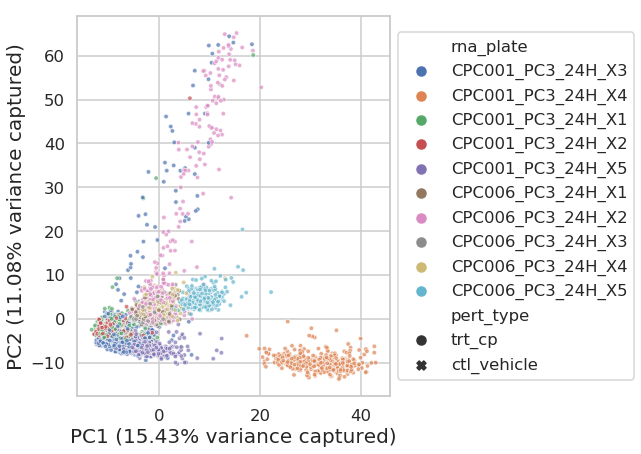

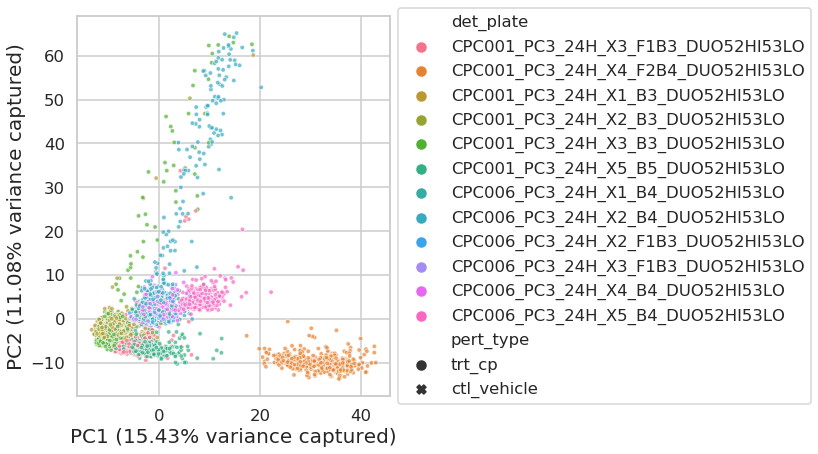

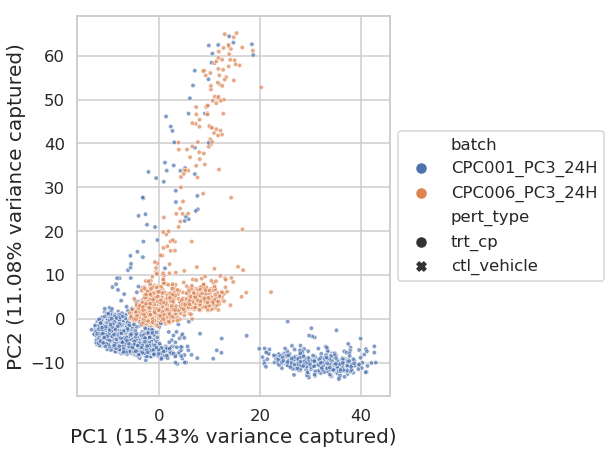

In [23]:
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='batch', style='pert_type', standardize=3)

In [24]:
mat_centered_by_rna = gctx_utils.mean_center(mat, inst_ids_pclb['rna_plate'])

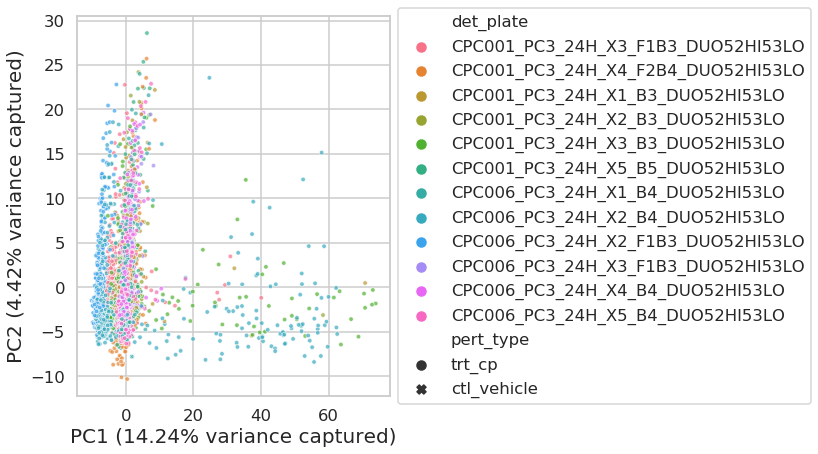

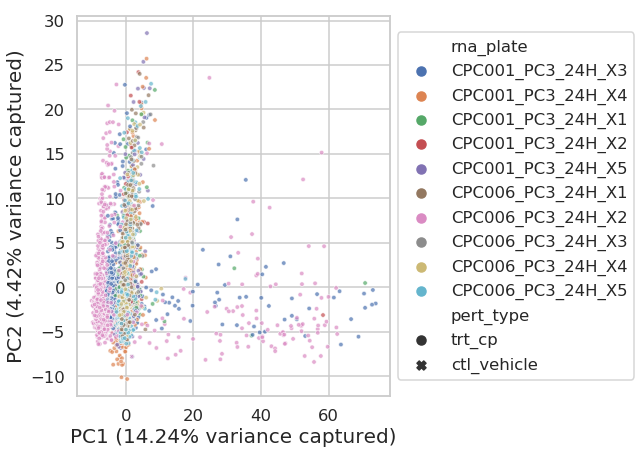

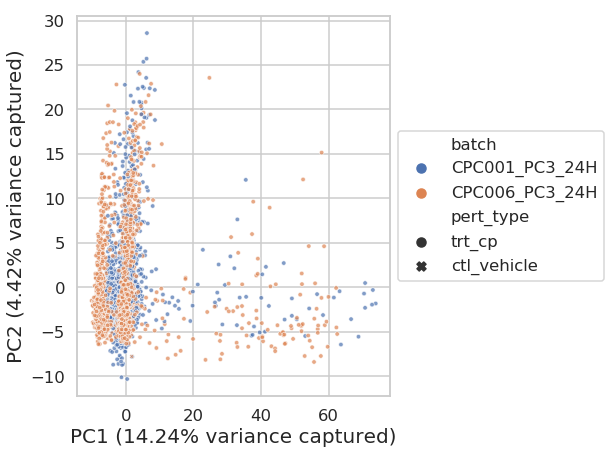

In [25]:
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='batch', style='pert_type', standardize=3)

In [26]:
mat_centered_by_det = gctx_utils.mean_center(mat, inst_ids_pclb['det_plate'])

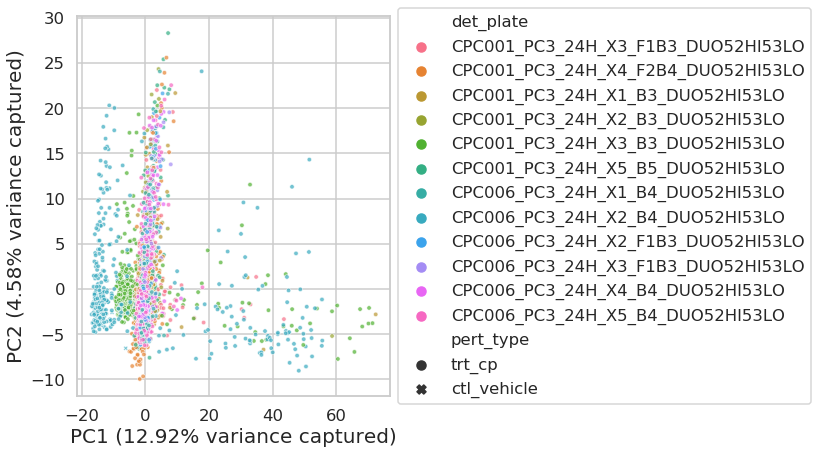

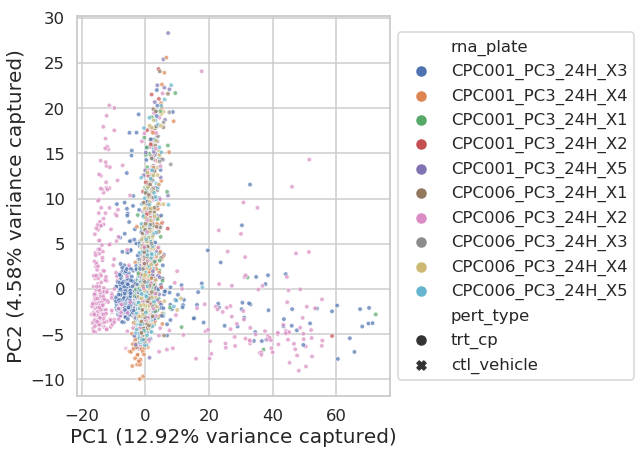

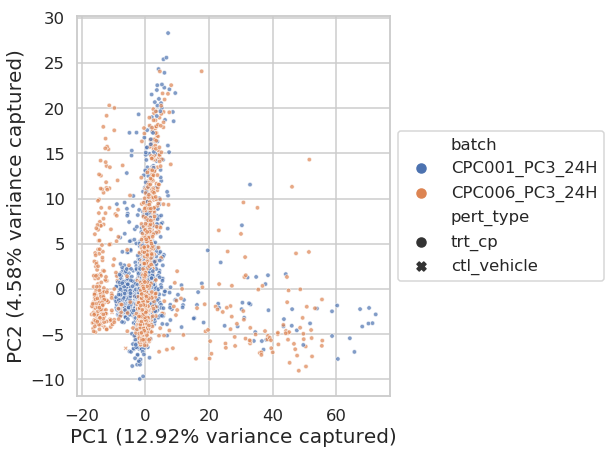

In [27]:
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='batch', style='pert_type', standardize=3)

## Load sig_info to compute signatures

In [48]:
sig_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_sig_info.txt.gz', 
                          compression='gzip',
                          sep='\t')
sig_info_df = sig_info_df.set_index('sig_id')
sig_info_df.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



(473647, 11)

In [49]:
sig_info_df.head()

pert_id     pert_iname  \
sig_id                                                                
AML001_CD34_24H:A05                             DMSO           DMSO   
AML001_CD34_24H:A06                             DMSO           DMSO   
AML001_CD34_24H:B05                             DMSO           DMSO   
AML001_CD34_24H:B06                             DMSO           DMSO   
AML001_CD34_24H:BRD-A03772856:0.37037  BRD-A03772856  BRD-A03772856   

                                         pert_type cell_id pert_dose  \
sig_id                                                                 
AML001_CD34_24H:A05                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:A06                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:B05                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:B06                    ctl_vehicle    CD34       0.1   
AML001_CD34_24H:BRD-A03772856:0.37037       trt_cp    CD34   0.37037   

                                      pert_dose_unit pert_idose  pert_time  \
sig_id                                                                       
AML001_CD34_24H:A05                                %      0.1 %         24   
AML001_CD34_24H:A06                                %      0.1 %         24   
AML001_CD34_24H:B05                                %      0.1 %         24   
AML001_CD34_24H:B06                                %      0.1 %         24   
AML001_CD34_24H:BRD-A03772856:0.37037             µM     500 nM         24   

                                      pert_time_unit pert_itime  \
sig_id                                                            
AML001_CD34_24H:A05                                h       24 h   
AML001_CD34_24H:A06                                h       24 h   
AML001_CD34_24H:B05                                h       24 h   
AML001_CD34_24H:B06                                h       24 h   
AML001_CD34_24H:BRD-A03772856:0.37037              h       24 h   

                                                                               distil_id  
sig_id                                                                                    
AML001_CD34_24H:A05                                         AML001_CD34_24H_X1_F1B10:A05  
AML001_CD34_24H:A06                                         AML001_CD34_24H_X3_F1B10:A06  
AML001_CD34_24H:B05                    AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X...  
AML001_CD34_24H:B06                                         AML001_CD34_24H_X3_F1B10:B06  
AML001_CD34_24H:BRD-A03772856:0.37037  AML001_CD34_24H_X1_F1B10:J04|AML001_CD34_24H_X...

In [51]:
sig_info_df = sig_info_df.query('cell_id == "PC3" & pert_type == "trt_cp"')
# sig_info_df = sig_info_df.query('cell_id == "NPC" & pert_type == "trt_cp"')
print(sig_info_df.shape)

(23123, 11)


In [52]:
sig_info_df['batch'] = sig_info_df.index.map(lambda x: x.split(':')[0])
sig_info_df['n_distil_ids'] = sig_info_df['distil_id'].map(lambda x: len(x.split('|')))

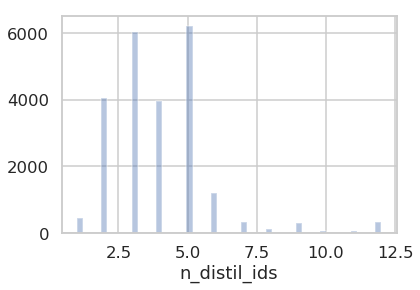

In [53]:
sns.distplot(sig_info_df['n_distil_ids'], kde=False)

In [54]:
# remove signatures with only one distil_id
sig_info_df = sig_info_df.query('n_distil_ids > 1')
sig_info_df.shape

(22664, 13)

In [55]:
sig_info_df['pert_id'].value_counts().head(10)

BRD-K81418486    173
BRD-A75409952    122
BRD-A19037878    121
BRD-A19500257    121
BRD-K27305650     49
BRD-A90490067     42
BRD-K02130563     37
BRD-A13084692     33
BRD-K88742110     32
BRD-K00627859     32
Name: pert_id, dtype: int64

In [56]:
sig_info_df['pert_iname'].value_counts().head(10)

vorinostat        173
wortmannin        126
trichostatin-a    125
geldanamycin      121
LY-294002          49
fulvestrant        49
panobinostat       37
sirolimus          35
troglitazone       33
PCI-34051          32
Name: pert_iname, dtype: int64

In [57]:
sig_info_df_sub = sig_info_df.loc[sig_info_df['pert_id'].isin(
        ['BRD-K81418486', 'BRD-A75409952', 'BRD-A19037878', 'BRD-A19500257'])]
sig_info_df_sub.shape

(537, 13)

# 2. Benchmark batch effect in Level 5 data (signatures)

In [58]:
gctx5 = h5py.File('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', 'r')

In [59]:
mat5 = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, 
                               cids=sig_info_df_sub.index.values.astype(np.str))
mat5.shape

(537, 978)

In [60]:
# Load level5 data from CD pipelines with and without batch effect corrections
gctx5_cd_center = h5py.File('data/results/CD_center_level5_PC3_n978x22664.gctx', 'r')
gctx5_cd_nocenter = h5py.File('data/results/CD_noncenter_level5_PC3_n978x22664.gctx', 'r')
gctx5_avg_center = h5py.File('data/results/Avg_center_level5_PC3_n978x22664.gctx', 'r')

mat5_cd_center = gctx_utils.slice_matrix(gctx5_cd_center, rids=LM_GENE_IDS, cids=sig_info_df_sub.index.values.astype(np.str), transpose=True)
mat5_cd_nocenter = gctx_utils.slice_matrix(gctx5_cd_nocenter, rids=LM_GENE_IDS, cids=sig_info_df_sub.index.values.astype(np.str), transpose=True)
mat5_avg_center = gctx_utils.slice_matrix(gctx5_avg_center, rids=LM_GENE_IDS, cids=sig_info_df_sub.index.values.astype(np.str), transpose=True)
print(mat5_cd_center.shape, mat5_cd_nocenter.shape, mat5_avg_center.shape)

(537, 978) (537, 978) (537, 978)


Text(0.5,1,'MODZ')

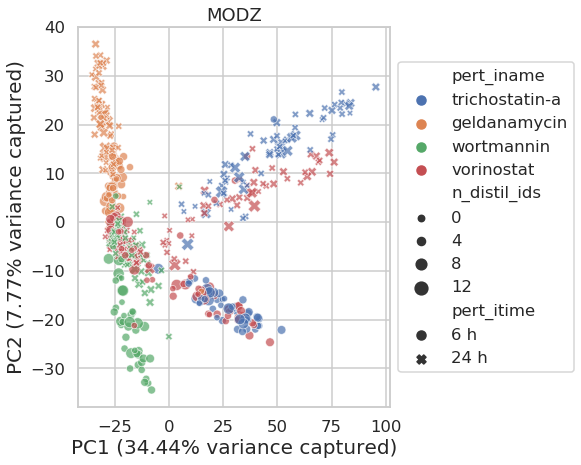

In [61]:
fig = plots.PCA_plot(mat5.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)
fig.get_axes()[0].set_title('MODZ')

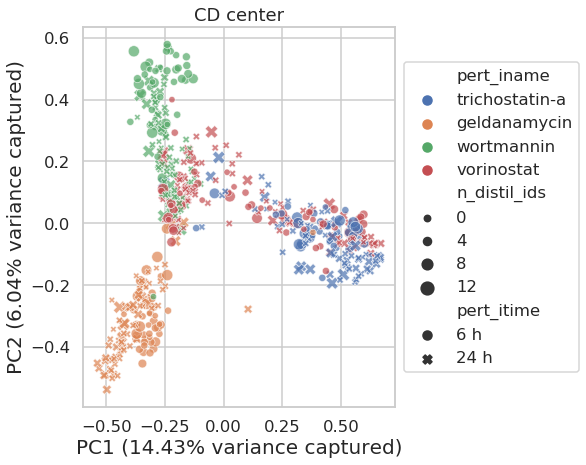

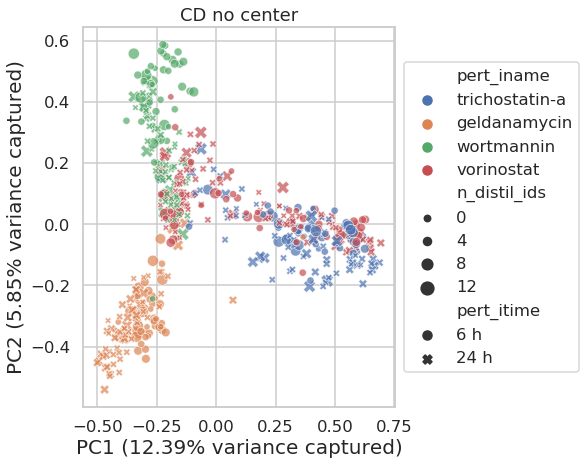

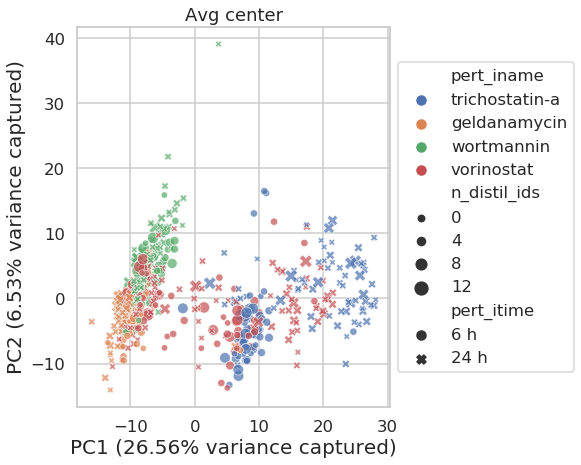

In [62]:
fig = plots.PCA_plot(mat5_cd_center.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)
fig.get_axes()[0].set_title('CD center');

fig = plots.PCA_plot(mat5_cd_nocenter.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)
fig.get_axes()[0].set_title('CD no center');

fig = plots.PCA_plot(mat5_avg_center.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='n_distil_ids',
                     standardize=3)
fig.get_axes()[0].set_title('Avg center');

In [63]:
sig_info_df_sub['batch_prefix'] = sig_info_df_sub['batch'].map(lambda x:x.split('_')[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [64]:
sig_info_df_sub['batch'].nunique()

73

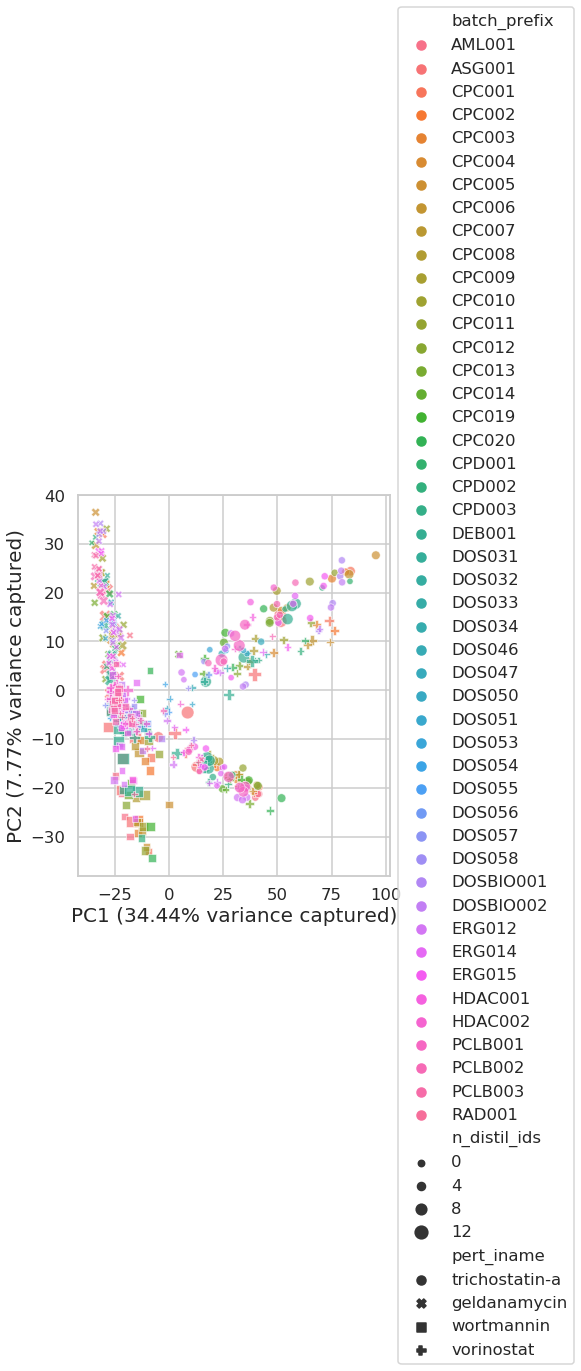

In [65]:
fig = plots.PCA_plot(mat5.T, sig_info_df_sub, hue='batch_prefix', style='pert_iname', 
                     size='n_distil_ids',
                     standardize=3)

In [68]:
import benchmarks

In [69]:
res_scores = benchmarks.compute_pairwise_connectivity_scores(mat5, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 6528 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 66828 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   16.3s finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 8052 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 85452 tasks      | elapsed:    9.8s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   16.1s finished


1306 35473 3380 103757


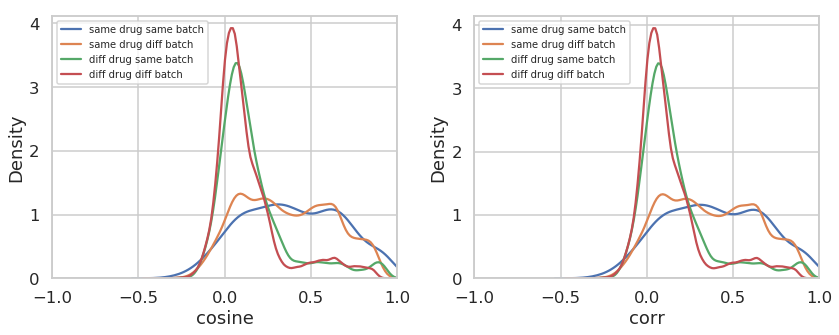

In [70]:
fig = benchmarks.density_plot_scores(res_scores, sig_info_df_sub)

719 36060 2048 105089


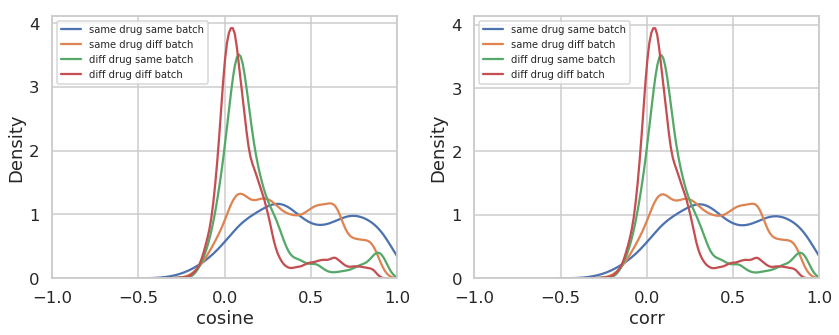

In [71]:
fig = benchmarks.density_plot_scores(res_scores, sig_info_df_sub, batch='batch')

In [72]:
res_scores_cd_center = benchmarks.compute_pairwise_connectivity_scores(mat5_cd_center, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 11364 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 126564 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   15.6s finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 8156 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 87956 tasks      | elapsed:   10.2s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   16.3s finished


719 36060 2048 105089


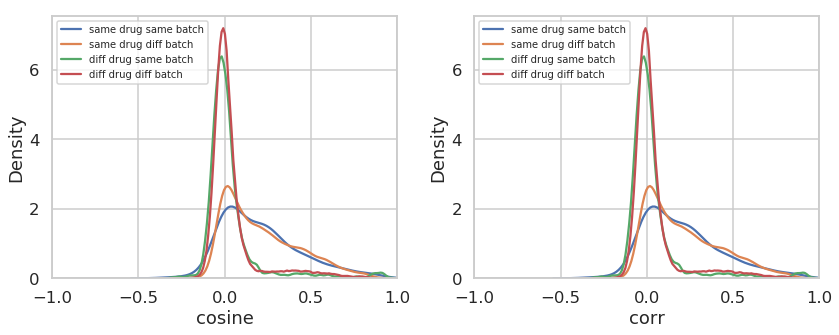

In [73]:
fig = benchmarks.density_plot_scores(res_scores_cd_center, sig_info_df_sub, batch='batch')

In [74]:
res_scores_cd_nocenter = benchmarks.compute_pairwise_connectivity_scores(mat5_cd_nocenter, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 12932 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   15.9s finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 12068 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 129668 tasks      | elapsed:   15.2s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   16.7s finished


719 36060 2048 105089


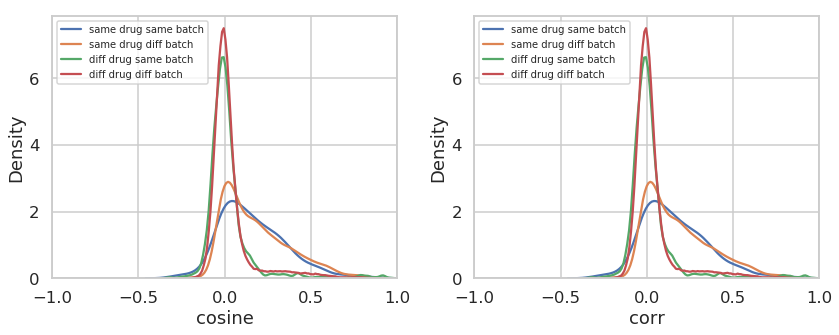

In [75]:
fig = benchmarks.density_plot_scores(res_scores_cd_nocenter, sig_info_df_sub, batch='batch')

In [76]:
res_scores_avg_center = benchmarks.compute_pairwise_connectivity_scores(mat5_avg_center, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 9080 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done 96980 tasks      | elapsed:   10.8s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   15.8s finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 10068 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 109068 tasks      | elapsed:   12.4s
[Parallel(n_jobs=6)]: Done 143916 out of 143916 | elapsed:   16.0s finished


719 36060 2048 105089


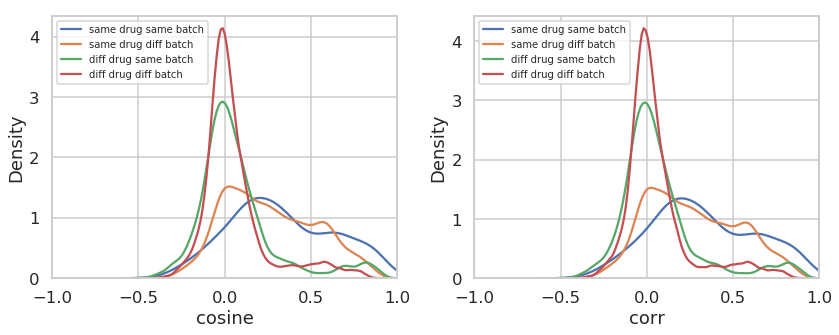

In [77]:
fig = benchmarks.density_plot_scores(res_scores_avg_center, sig_info_df_sub, batch='batch')

## Visualizing the signatures

In [78]:
# Load data downloaded from RepurposingHub
drug_moa_df = pd.read_csv('data/parsed_Repurposing_Hub.csv').set_index('pert_id')
print(drug_moa_df.shape)
drug_moa_df.head()

(6172, 5)


Name                                         MOA  \
pert_id                                                               
BRD-K38019854  A-317491              purinergic receptor antagonist   
BRD-A40302156   A-33903                                         NaN   
BRD-K06182768     A-366  histone lysine methyltransferase inhibitor   
BRD-K78177893  A-674563                               AKT inhibitor   
BRD-K03301001       A-7                       calmodulin antagonist   

                           Target Indication        Phase  
pert_id                                                    
BRD-K38019854               P2RX3        NaN  Preclinical  
BRD-A40302156                 NaN        NaN      Phase 2  
BRD-K06182768        EHMT1, EHMT2        NaN  Preclinical  
BRD-K78177893  AKT1, PKIA, PRKACA        NaN  Preclinical  
BRD-K03301001                 NaN        NaN  Preclinical

In [79]:
# Keep signatures from drugs with known MOA/Targets
sig_info_df_known_drugs = sig_info_df.loc[sig_info_df.pert_id.isin(drug_moa_df.index)]
sig_info_df_known_drugs.shape

(6285, 13)

In [80]:
# Retrieve all signatures
sig_mat = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, 
                                  cids=sig_info_df_known_drugs.index.values.astype(np.str))
sig_mat.shape

(6285, 978)

In [81]:
pca = decomposition.PCA(n_components=50)
sig_mat_pca = pca.fit_transform(sig_mat)

tsne = manifold.TSNE(verbose=10)
sig_mat_tsne = tsne.fit_transform(sig_mat_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6285 samples in 0.011s...
[t-SNE] Computed neighbors for 6285 samples in 3.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6285
[t-SNE] Computed conditional probabilities for sample 2000 / 6285
[t-SNE] Computed conditional probabilities for sample 3000 / 6285
[t-SNE] Computed conditional probabilities for sample 4000 / 6285
[t-SNE] Computed conditional probabilities for sample 5000 / 6285
[t-SNE] Computed conditional probabilities for sample 6000 / 6285
[t-SNE] Computed conditional probabilities for sample 6285 / 6285
[t-SNE] Mean sigma: 3.899958
[t-SNE] Computed conditional probabilities in 0.390s
[t-SNE] Iteration 50: error = 89.5998611, gradient norm = 0.0147174 (50 iterations in 5.142s)
[t-SNE] Iteration 100: error = 87.0993195, gradient norm = 0.0080126 (50 iterations in 3.164s)
[t-SNE] Iteration 150: error = 87.0126419, gradient norm = 0.0086752 (50 iterations in 2.359s)
[t-SNE] Iteration 200: error = 

In [82]:
sig_info_df_known_drugs.head()

pert_id  pert_iname pert_type  \
sig_id                                                                     
AML001_PC3_6H:BRD-A45664787:0.37037  BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-A45664787:1.11111  BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-A45664787:10       BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-A45664787:3.33333  BRD-A45664787    iloprost    trt_cp   
AML001_PC3_6H:BRD-K27316855:0.37037  BRD-K27316855  calcitriol    trt_cp   

                                    cell_id pert_dose pert_dose_unit  \
sig_id                                                                 
AML001_PC3_6H:BRD-A45664787:0.37037     PC3   0.37037             µM   
AML001_PC3_6H:BRD-A45664787:1.11111     PC3   1.11111             µM   
AML001_PC3_6H:BRD-A45664787:10          PC3        10             µM   
AML001_PC3_6H:BRD-A45664787:3.33333     PC3   3.33333             µM   
AML001_PC3_6H:BRD-K27316855:0.37037     PC3   0.37037             µM   

                                    pert_idose  pert_time pert_time_unit  \
sig_id                                                                     
AML001_PC3_6H:BRD-A45664787:0.37037     500 nM          6              h   
AML001_PC3_6H:BRD-A45664787:1.11111       1 µM          6              h   
AML001_PC3_6H:BRD-A45664787:10           10 µM          6              h   
AML001_PC3_6H:BRD-A45664787:3.33333       3 µM          6              h   
AML001_PC3_6H:BRD-K27316855:0.37037     500 nM          6              h   

                                    pert_itime  \
sig_id                                           
AML001_PC3_6H:BRD-A45664787:0.37037        6 h   
AML001_PC3_6H:BRD-A45664787:1.11111        6 h   
AML001_PC3_6H:BRD-A45664787:10             6 h   
AML001_PC3_6H:BRD-A45664787:3.33333        6 h   
AML001_PC3_6H:BRD-K27316855:0.37037        6 h   

                                                                             distil_id  \
sig_id                                                                                   
AML001_PC3_6H:BRD-A45664787:0.37037  AML001_PC3_6H_X1_F1B10:J24|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-A45664787:1.11111  AML001_PC3_6H_X1_F1B10:J23|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-A45664787:10       AML001_PC3_6H_X1_F1B10:I23|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-A45664787:3.33333  AML001_PC3_6H_X1_F1B10:I24|AML001_PC3_6H_X1_F1...   
AML001_PC3_6H:BRD-K27316855:0.37037  AML001_PC3_6H_X1_F1B10:J22|AML001_PC3_6H_X2_F1...   

                                             batch  n_distil_ids  
sig_id                                                            
AML001_PC3_6H:BRD-A45664787:0.37037  AML001_PC3_6H             6  
AML001_PC3_6H:BRD-A45664787:1.11111  AML001_PC3_6H             6  
AML001_PC3_6H:BRD-A45664787:10       AML001_PC3_6H             6  
AML001_PC3_6H:BRD-A45664787:3.33333  AML001_PC3_6H             6  
AML001_PC3_6H:BRD-K27316855:0.37037  AML001_PC3_6H             3

In [83]:
sig_info_df_known_drugs = sig_info_df_known_drugs.merge(drug_moa_df, 
                                                        left_on='pert_id', 
                                                        right_index=True, 
                                                        how='left')

In [84]:
frequent_MOAs = set(sig_info_df_known_drugs['MOA'].value_counts()[:19].index)
sig_info_df_known_drugs['MOA_frequent'] = [moa if moa in frequent_MOAs else 'other' \
                                           for moa in sig_info_df_known_drugs['MOA']]

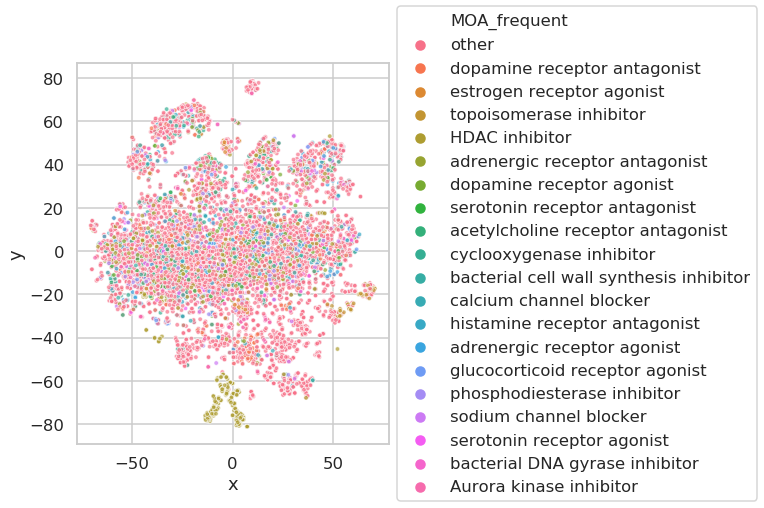

In [85]:
fig = plots.scatter_plot(sig_mat_tsne, sig_info_df_known_drugs, hue='MOA_frequent')

In [86]:
import umap

In [87]:
sig_mat_umap =  umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean').fit_transform(sig_mat)
sig_mat_umap.shape

(6285, 2)

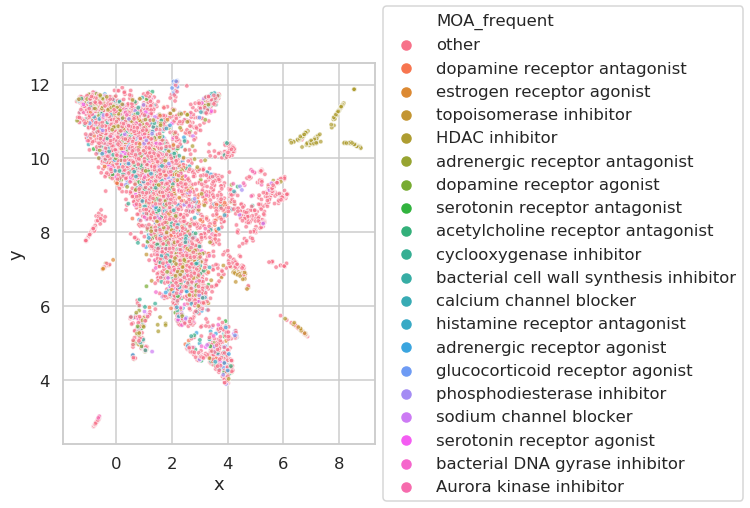

In [88]:
fig = plots.scatter_plot(sig_mat_umap, sig_info_df_known_drugs, hue='MOA_frequent')

In [89]:
sig_mat_umap_pca =  umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean').fit_transform(sig_mat_pca)
sig_mat_umap_pca.shape

(6285, 2)

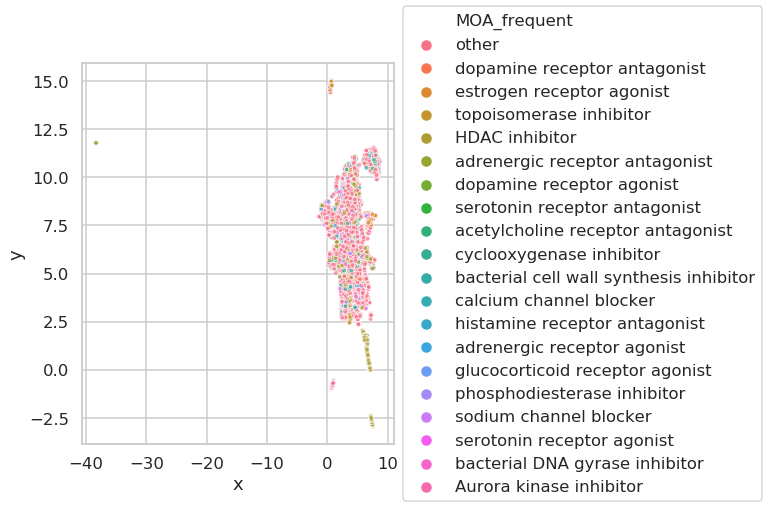

In [90]:
fig = plots.scatter_plot(sig_mat_umap_pca, sig_info_df_known_drugs, hue='MOA_frequent')

In [91]:
plots.plotly_webgl_scatter(sig_mat_tsne, sig_info_df_known_drugs, 
                     hue='MOA_frequent', 
                     label_cols=['pert_iname', 'MOA'])

In [145]:
import graph_utils

In [146]:
sig_mat.shape

(6285, 978)

In [147]:
G = graph_utils.create_knn_graph(sig_mat[:100], k=10)
G.number_of_nodes(), G.number_of_edges()

(100, 823)

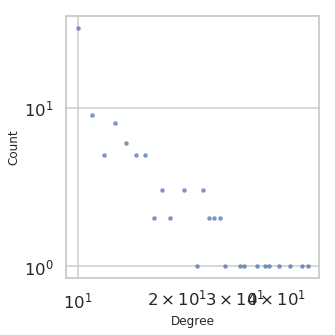

In [148]:
graph_utils.plot_degree_distribution(G)

In [149]:
G = ig.Graph.Adjacency((nx.to_numpy_matrix(G) > 0).tolist(), mode=ig.ADJ_UNDIRECTED)

In [150]:
G.is_directed()

False

In [151]:
layt = G.layout('kk', dim=3) 

In [157]:
G.es.select([])

In [166]:
list(G.es)[0].tuple

(0, 2)

In [179]:
edges = [e.tuple for e in list(G.es)]

In [180]:
edges[:10]

[(0, 2),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 14),
 (0, 15),
 (0, 22),
 (0, 41),
 (0, 48),
 (0, 53)]

In [178]:
len(list(G.es))

823

In [119]:
np.asarray(layt.coords).shape

(100, 3)

In [178]:
import json
from urllib.request import urlopen
import igraph as ig

data = []
# req = urllib2.Request("https://raw.githubusercontent.com/plotly/datasets/master/miserables.json")
# opener = urllib2.build_opener()
# f = opener.open(req)
f = urlopen('https://raw.githubusercontent.com/plotly/datasets/master/miserables.json')
data = json.loads(f.read())

data.keys()


dict_keys(['nodes', 'links'])

In [179]:
N=len(data['nodes'])
N

77

In [198]:
Edges[:5]

[(1, 0), (2, 0), (3, 0), (3, 2), (4, 0)]

In [120]:
len(layt.coords)

100

In [181]:
L=len(data['links'])
Edges=[(data['links'][k]['source'], data['links'][k]['target']) for k in range(L)]

G=ig.Graph(Edges, directed=False)


In [182]:
labels=[]
group=[]
for node in data['nodes']:
    labels.append(node['name'])
    group.append(node['group'])


In [183]:
layt=G.layout('kk', dim=3) 

In [185]:
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]  
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]  


In [186]:

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color=group,
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )


In [187]:
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)